In [1]:
import torch
import numpy as np
from sbi.neural_nets import posterior_nn
from sbi.neural_nets.embedding_nets import CNNEmbedding
from sbi.inference import NPE, simulate_for_sbi
from sbi.utils import BoxUniform
from sbi import analysis

from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)

import matplotlib.pyplot as plt

In [2]:
ts, dt = (60.0, 0.1)
def mass_spring_damper_simulator(theta):
    m, k, b = theta
    steps = int(ts/dt)
    x0 = torch.normal(mean=10.0, std=3.0, size=(1,))
    v0 = torch.normal(mean=3.0, std=1.0, size=(1,))
    x, v = float(x0), float(v0)  # Initial conditions
    force = np.cos(np.arange(steps) * dt * 10)
    trajectory = []

    for f in force:
        x_new = x + dt * v
        v_new = v + dt * (-k * x / m - b * v / m + f / m)
        x, v = x_new, v_new
        trajectory.append([x, v])

    trajectory = torch.tensor(trajectory)
    noise_std = 0.1 
    trajectory += torch.randn_like(trajectory) * noise_std
    return trajectory.clone().detach()

In [3]:
def mass_spring_damper_fixed_simulator(theta):
    m, k, b = theta
    steps = int(ts/dt)
    x, v = 3, 10  # Initial conditions
    force = np.cos(np.arange(steps) * dt * 10)
    trajectory = []

    for f in force:
        x_new = x + dt * v
        v_new = v + dt * (-k * x / m - b * v / m + f / m)
        x, v = x_new, v_new
        trajectory.append([x, v])

    return torch.tensor(trajectory)

In [4]:
true_parameter = torch.tensor([7.5, 3.0, 1.5])
x_observed = mass_spring_damper_fixed_simulator(true_parameter)

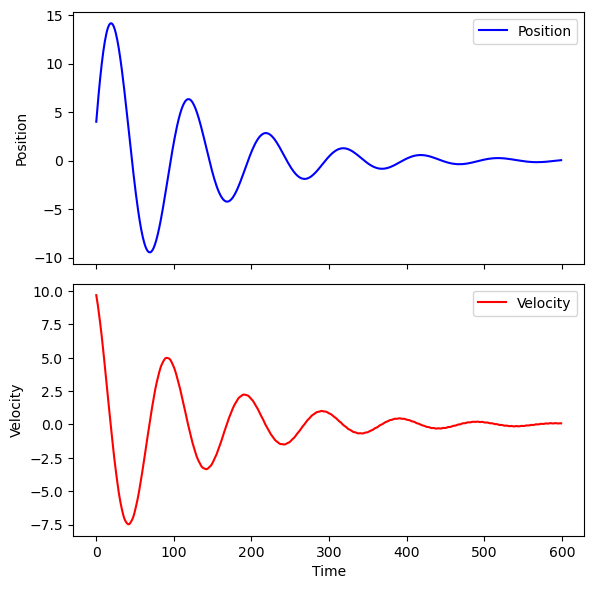

In [5]:
t = torch.arange(len(x_observed))

fig, axes = plt.subplots(2, 1, figsize=(6, 6), sharex=True)
# Plot first column
axes[0].plot(t, x_observed[:, 0], label="Position", color="b")
axes[0].set_ylabel("Position")
axes[0].legend()

# Plot second column
axes[1].plot(t, x_observed[:, 1], label="Velocity", color="r")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Velocity")
axes[1].legend()

# Show the plots
plt.tight_layout()
plt.show()

In [6]:
dim = int(ts/dt) * 2
embedding_net = CNNEmbedding(
    input_shape=(dim, ), 
    output_dim=16,
    # out_channels_per_layer=[64, 128, 256],
    # num_conv_layers=3,
    # num_linear_layers=3,
    # num_linear_units=200,
)

In [7]:
prior = BoxUniform(low=torch.tensor([6.5, 2.0, 0.5]), 
                   high=torch.tensor([8.5, 4.0, 2.5]))

prior, num_parameters, prior_returns_numpy = process_prior(prior)

In [8]:
simulator_wrapper = process_simulator(mass_spring_damper_simulator, prior, prior_returns_numpy)
check_sbi_inputs(simulator_wrapper, prior)

In [9]:
neural_posterior = posterior_nn(model='maf', embedding_net=embedding_net)

In [10]:
inference = NPE(prior=prior, density_estimator=neural_posterior)
# inference = NPE(prior=prior)

In [11]:
theta, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [12]:
# Flatten the input tensor x
x_flattened = x.view(x.size(0), -1)
density_estimator = inference.append_simulations(theta, x_flattened).train()

 Neural network successfully converged after 175 epochs.

In [13]:
posterior = inference.build_posterior(density_estimator)

In [14]:
samples = posterior.sample((5000,), x=x_observed.flatten())

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

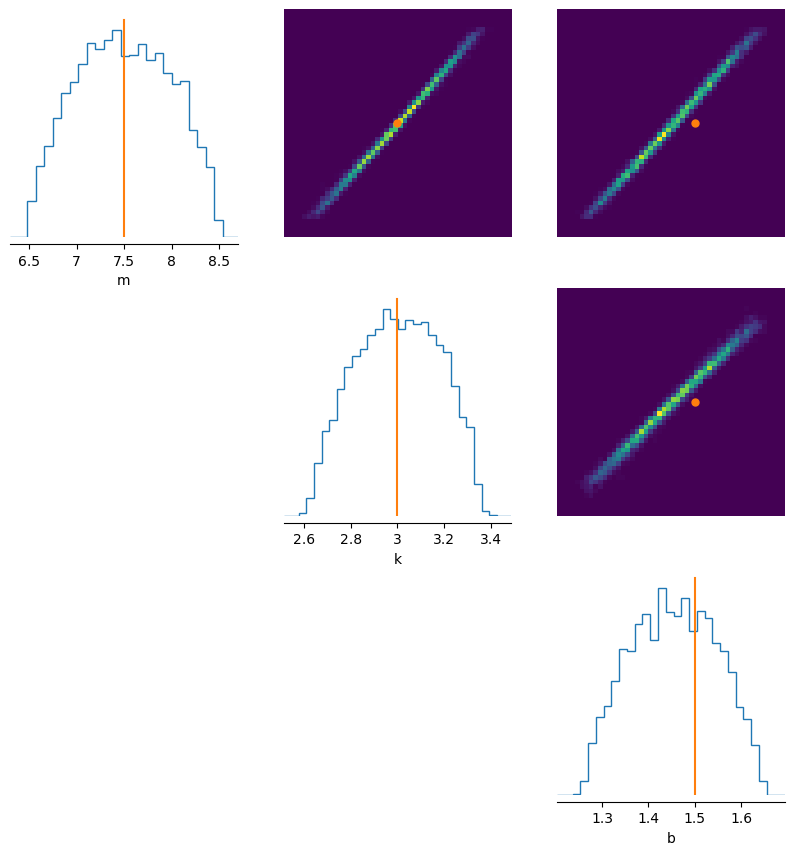

In [15]:
fig, ax = analysis.pairplot(
    samples,
    points=true_parameter.unsqueeze(0),
    labels=["m", "k", "b"], 
)

In [21]:
# Draw a sample from the posterior and convert to numpy for plotting.
posterior_sample = posterior.sample((1,), x=x_observed.flatten()).numpy()
posterior_min = np.array([[6.5,   2,  0.5]])
posterior_max = np.array([[8.5,   4,  2.5]])
x_min = mass_spring_damper_fixed_simulator(posterior_min.squeeze())
x_max = mass_spring_damper_fixed_simulator(posterior_max.squeeze())
x_posterior = mass_spring_damper_fixed_simulator(posterior_sample.squeeze())
print(posterior_sample)

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

[[7.2108164 2.9129312 1.4145235]]


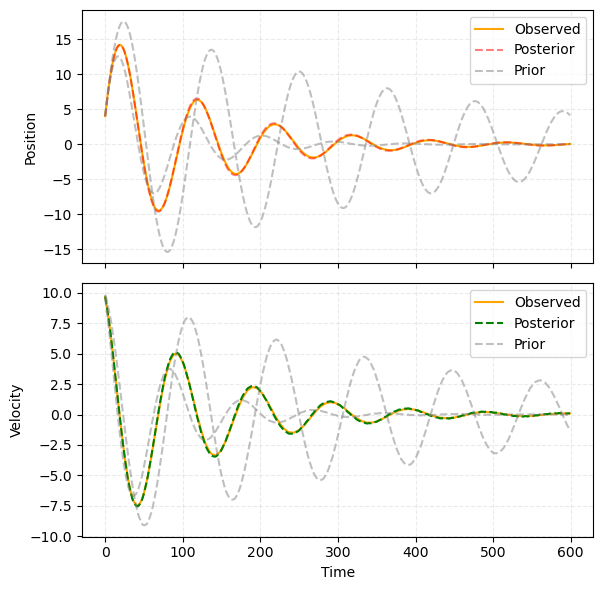

In [17]:
fig, axes = plt.subplots(2, 1, figsize=(6, 6), sharex=True)
# Plot first column
axes[0].plot(t, x_observed[:, 0], label="Observed",color="orange")
axes[0].plot(t, x_posterior[:, 0], label="Posterior", linestyle='--' ,color="red", alpha=0.5)
axes[0].plot(t, x_min[:, 0], label="Prior", linestyle='--' ,color="grey", alpha=0.5)
axes[0].plot(t, x_max[:, 0], linestyle='--' ,color="grey", alpha=0.5)
axes[0].set_ylabel("Position")
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.25)

# Plot second column
axes[1].plot(t, x_observed[:, 1], label="Observed", color="orange")
axes[1].plot(t, x_posterior[:, 1], label="Posterior", linestyle='--', color="green")
axes[1].plot(t, x_min[:, 1], label="Prior", linestyle='--', color="grey", alpha=0.5)
axes[1].plot(t, x_max[:, 1], linestyle='--', color="grey", alpha=0.5)
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Velocity")
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.25)

# Show the plots
plt.tight_layout()
plt.show()